Versions:
* v1: Nepal Data, EMA implementation start. First working test with EMA
* v2: Finish of first iteration of Optimisation and Uncertainty analysis
* v3: Finish first version of Robustness analysis & MORDM
* v4: Clean up MORDM - very minor
* v5: Change model v1 to v2 + clean up

TODO: 

* Disruption factor --> roads and demand --> Check demand. not roads
* Proper naming of all variables:
    - Start_situation t
        - Optional_policies
        - Best_estimate_results_policies	
        - Nondominated_best_estimate_policies
        - All_Scenarios_results_nondominated_policies
        - Robust_Nondominated _policies
            - End_situation t == start situation t+1
		

* FL not random generation
* distances based on OSRM route matrix

<b> OSRM </b><br>
for installation:

pip install git+https://github.com/ustroetz/python-osrm

In [1]:
# Standard imports
import random
import pandas as pd
import numpy as np

# Own Model import
from lib.fl_model_v2 import *

# for natural sorting
import re

#for nondominated sorting
import lib.pareto as pareto
from lib.list_imports import find_loaded_modules

# for parallel plotting
from lib.parallel_plotting import plot_optimal

# For checking ema running time
import time

In [2]:
import ema_workbench as ema
from ema_workbench.em_framework import (Policy, IntegerParameter, Constant,
                                        RealParameter, ScalarOutcome,
                                        perform_experiments, Model)
from ema_workbench import ema_logging
# from ema_workbench.em_framework.

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [3]:
# %load https://gist.github.com/TRomijn/d9d28ba7b7d5eeac1deea5a26dd326b2/raw/loaded_modules.py

'''
original author: kinverarity1

List loaded modules and packages, and show their version numbers
and/or Git repository's HEAD commit SHA.


Changes:
Minor changes to make compatible with Python 3
'''
# Standard library modules
import types
import os

# Third-party packages
import git      # GitPython


def module_path(mod):
    '''Returns path to the file that module *mod* comes from.
    If it doesn't come from a file, return None.'''
    if hasattr(mod, '__file__'):
        return os.path.abspath(os.path.dirname(mod.__file__))
    else:
        return None

    
def from_git_repo(mod):
    '''Does the module *mod* reside in a Git repository?'''
    path = module_path(mod)
    if path:
        try:
            repo = git.Repo(path)
        except:
            return False
        else:
            return True
    else:
        return False

    
def git_path_sha(mod, slice=slice(0, 8, 1)):
    '''Return SHA hash for the HEAD commit for the repository
    that the module *mod* resides in.'''
    repo = git.Repo(module_path(mod))
    return repo.git_dir, repo.head.commit.hexsha[:8]


def module_version(mod):
    '''Return version string for module *mod*, or nothing if
    it doesn't have a "version" or "__version__" attribute.'''
    version = []
    if hasattr(mod, '__dict__'):
        keys = []
        for key in mod.__dict__.keys():
            if key.lower() == 'version' or key.lower() == '__version__':
                v = mod.__dict__[key]
                if isinstance(v, str):
                    version.append(v)
        if keys:
            print (mod, keys)
    if version:
        return ', '.join(version)
    else:
        return ''

    
def find_loaded_modules(only_versioned_modules=True):
    '''Return list of loaded modules for which there is a version
    number or a Git repository commit SHA.
    
    Return a list of *(name, version, path_to_git_repo, git_head_sha)*,
    which has an HTML property for pretty display in IPython Notebooks.
        
    '''
    def list_of_lists_to_HTML(lists, header_row=None):
        '''Convert a list of a list of strings to a HTML table.'''
        s = '<table>'
        if header_row:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<th>%s</th>' % item for item in header_row])
            s += '\n\t</tr>'
        for inner_list in lists:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<td>%s</td>' % item for item in inner_list])
            s += '\n\t</tr>'
        s += '\n</table>'
        return s
    
    class LoadedModules(list):
        '''Very simple wrapper for a list of lists of strings, with an attribute
        for display in IPython Notebooks.'''
        def __init__(self, *args, **kwargs):
            list.__init__(self, *args, **kwargs)
            
        @property
        def HTML(self):
            from IPython.display import HTML
            return HTML(
                    list_of_lists_to_HTML(
                            self, header_row=['Name', 'Version', 'Path', 'SHA']))
                    
    objs = LoadedModules()
    for i, mod in enumerate(globals().values()):
        if isinstance(mod, types.ModuleType):
            if hasattr(mod, '__name__'):
                name = mod.__name__
            else:
                name = ''
            
            if from_git_repo(mod):
                path, sha = git_path_sha(mod)
            else:
                path = ''
                sha = ''
            
            version = module_version(mod)
            
            if only_versioned_modules:
                flag = version or (path and sha)
            else:
                flag = True
            
            if flag:
                objs.append([mod.__name__, version, path, sha])
    objs.sort(key=lambda r: r[0])
    return objs


    
    

In [4]:
find_loaded_modules().HTML

Name,Version,Path,SHA
ema_workbench,1.1.3,,
git,2.1.9,,
json,2.0.9,,
lib.pareto,1.1.1-3,,
numpy,1.14.2,,
pandas,0.22.0,,
re,2.2.1,,


# FL Model test

Moved to different Notebook

# FL Model Nepal

## Nepal Data

In [5]:
Nepal = pd.read_csv("Data/Nepal Cities Population.csv", usecols=[1,2,3,4])

# Take only larger cities, because of many null values under 50000 inhabitants. 
# TODO find better dataset with population and coordinates
Nepal = Nepal [Nepal.Population >= 50000]
Nepal.head(1)

,City,Population,Latitude (DD),Longitude (DD)
0,Kathmandu,743300,27.71,85.31


In [6]:
airports = pd.read_csv("Data/Nepal Airports.csv", usecols=[0,5,6])
int_airports = airports[airports['Airport'] == "Tribhuvan intl"]
int_airports.head()

,Airport,Latitude (DD),Longitude (DD)
7,Tribhuvan intl,27.7,85.36


### Unfinished: Get Nepal Facility Location nodes -  Do: GIS analysis

In [2]:
import osmnx as ox
# G = ox.graph_from_place('Amsterdam, The Netherlands',infrastructure='way["primary"]')
gdf = ox.pois_from_place(place='Kamppi, Helsinki, Finland')

Exception: Server returned no JSON data.
<Response [400]> Bad Request
<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN"
    "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">
<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en">
<head>
  <meta http-equiv="content-type" content="text/html; charset=utf-8" lang="en"/>
  <title>OSM3S Response</title>
</head>
<body>

<p>The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.</p>
<p><strong style="color:#FF0000">Error</strong>: line 1: parse error: ';' expected - ')' found. </p>
<p><strong style="color:#FF0000">Error</strong>: line 1: parse error: Unexpected end of input. </p>
<p><strong style="color:#FF0000">Error</strong>: line 1: static error: Element "print" cannot be subelement of element "union". </p>

</body>
</html>


In [3]:
ox.__version__

'0.8dev'

In [4]:
boston_q = "Boston, Massachusetts, United States of America"
boston_poly = ox.gdf_from_place(boston_q, buffer_dist=2000)
universities = ox.pois_from_polygon(boston_poly.geometry.values[0], amenities=['university'])
list(universities.name.unique())

Exception: Server returned no JSON data.
<Response [400]> Bad Request
<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN"
    "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">
<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en">
<head>
  <meta http-equiv="content-type" content="text/html; charset=utf-8" lang="en"/>
  <title>OSM3S Response</title>
</head>
<body>

<p>The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.</p>
<p><strong style="color:#FF0000">Error</strong>: line 1: parse error: ';' expected - ')' found. </p>
<p><strong style="color:#FF0000">Error</strong>: line 1: parse error: Unexpected end of input. </p>
<p><strong style="color:#FF0000">Error</strong>: line 1: static error: Element "print" cannot be subelement of element "union". </p>

</body>
</html>


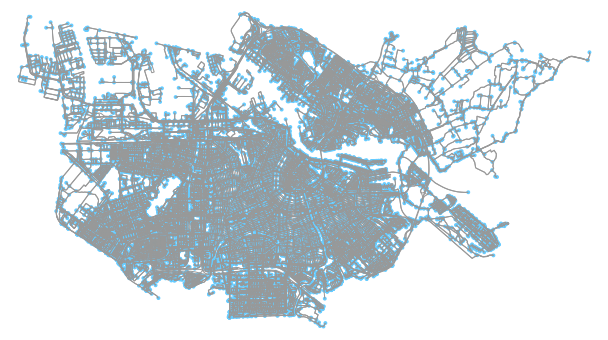

(<Figure size 1288.72x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1936d4c6c88>)

In [11]:
ox.plot_graph(G)

### Format DPs, SPs random Data FLS, 

In [7]:
DPs = Nepal
np.random.seed(0)
DPs['Demand_estimate'] = np.random.randint(0, 100, DPs.shape[0]) * DPs['Population']  # change random for impact factor
DPs['Demand_lower'] = DPs['Demand_estimate'] * 0.9
DPs['Demand_upper'] = DPs['Demand_estimate'] * 1.1
DPs['Demand_actual'] = np.random.uniform(DPs['Demand_lower'],DPs['Demand_upper'])
DPs['Demand_actual'] = DPs['Demand_actual'].apply(int)
DPs.head()

,City,Population,Latitude (DD),Longitude (DD),Demand_estimate,Demand_lower,Demand_upper,Demand_actual
0,Kathmandu,743300,27.71,85.31,32705200,29434680.0,35975720.0,32574229
1,Biratnagar,178000,26.46,87.28,8366000,7529400.0,9202600.0,8186607
2,Lalitpur,172400,27.68,85.32,11033600,9930240.0,12136960.0,11775231
3,Pokhara,169700,28.22,83.99,11369900,10232910.0,12506890.0,11000142
4,Birganj,119500,27.02,84.87,8006500,7205850.0,8807150.0,8243767


In [8]:
SPs = int_airports.reset_index(drop=True)
SPs

,Airport,Latitude (DD),Longitude (DD)
0,Tribhuvan intl,27.7,85.36


In [9]:
long = np.random.uniform(DPs['Longitude (DD)'].min(),
                         DPs['Longitude (DD)'].max(), 20)
lat = np.random.uniform(DPs['Latitude (DD)'].min(), DPs['Latitude (DD)'].max(),
                        20)
FLs = pd.DataFrame([lat, long], index=['Lat', 'Lon']).T
FLs['Name'] = ['FLO{}'.format(i) for i in range(FLs.shape[0])]
FLs = FLs[['Name', 'Lat', 'Lon']]
FLs.head()

,Name,Lat,Lon
0,FLO0,27.272618,83.818851
1,FLO1,26.556064,81.684449
2,FLO2,28.045685,85.775302
3,FLO3,28.857373,81.908969
4,FLO4,28.091976,81.304671


## Nepal Instantiation 

In [10]:
# 0. Instantiate

# General
# Coordinates
# all large cities to demand points
DPY = {"DPY{}".format(i): y for i,y in enumerate(Nepal['Latitude (DD)'])}
DPX = {"DPX{}".format(i): x for i,x in enumerate(Nepal['Longitude (DD)'])}

# all international airports to supply points:
SPY = {"SPY{}".format(i): y for i,y in enumerate(int_airports['Latitude (DD)'])}
SPX = {"SPX{}".format(i): x for i,x in enumerate(int_airports['Longitude (DD)'])}

# Facility locations
FLX = {"FLX{}".format(i): x for i,x in enumerate(FLs['Lon'])}
FLY = {"FLY{}".format(i): y for i,y in enumerate(FLs['Lat'])}


# Population demand points
DPpop = {"DPpop{}".format(i): pop for i,pop in enumerate(Nepal['Population'])}
# DPpop = {"DPpop{}".format(i): random.uniform(10,100) for i in range(nr_of_DPs)}



# DSR = Disruption Demand Points
# .5, 1.5: 50% of the time more or less, for traveling that distance
DSRDP = {"DSRDP{}".format(i): random.uniform (1, 2) for i in range(len(DPX))}
DSRFL = {"DSRFL{}".format(i): random.uniform (1, 2) for i in range(len(FLX))}

# Decision Variables
start_situation = {key:0 for key in FLs.Name}

## Nepal Model Evaluator

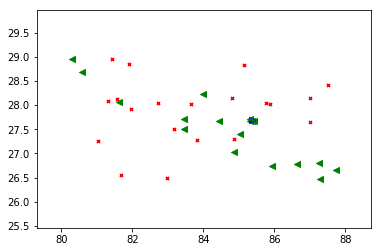

(40873233.48030245, 14, 1904623.5327162887, 0.6012164725442156, 0)

In [11]:
FL_model(
    100,
    1,
    True,
    FL_range=10,
    dist_method="great_circle",
    **SPX,
    **SPY,
    **DPX,
    **DPY,
    **FLX,
    **FLY,
    **start_situation,
    **DSRDP,
    **DSRFL,
    **DPpop)

# Multi-Objective Optimisation Framework

Pseudocode:

    Current situation
    Create possible options (full factorial)
    Evaluate all possible options
    Check pareto front of outcomes

In [12]:
current_situation = start_situation

In [13]:
def create_policies(FL_dict, print_pols=False):
    """
    Takes the current network of Facility Locations and returns all possible policies for one added FL.
    
    Input: current option (Dict of FLs)
    Output: List of options (Dicts of FLs)
    
    Printing module not completely reliable. doesnt print whats actually in thereTODO
    """
    def natural_key(string_):
        return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]
    
    # All FL names
    FL_keys = sorted(FL_dict.keys(),key=natural_key)
    # All FL values indicating whether operational
    FL_values = [FL_dict[key] for key in FL_keys]
    
    i_operational_fls = i_FL_op = [i for i,x in enumerate(FL_values) if x == 1]
    
    # Create list of policies  
    pols = np.identity(len(FL_keys))
    # Set already operational facilities to operational
    pols[:,i_operational_fls] = 1
    
    #Delete policies where no new FLs are placed 
    new_n_operational_fls = sum(FL_values) + 1
    pols = pols[pols.sum(axis = 1) == new_n_operational_fls]

    
    # Return a list of dictionaries
    policy_list = []
    for pol in pols:
        policy_list.append({key:value for key,value in zip(FL_keys,pol)})
    
    if print_pols == True:
        print("total policies:",len(policy_list))
        for n,i in enumerate(policy_list):
            for v in i.values():
                print (int(v), end='')
            print(" <- policy {}".format(n))
                
    return policy_list

In [14]:
optional_policies = create_policies(current_situation, print_pols=False)

In [15]:
# %%timeit
# Evaluate all optional policies with best estimate values
best_est_results_opt_pols = []
for policy in optional_policies:
    best_est_results_opt_pols.append(
        FL_model(
            unit_opening_costs=100,
            unit_transport_cost=1,
            graphical_representation=False,
            FL_range=50,
            dist_method="great_circle",
            lorry_speed=60,
            **SPX,
            **SPY,
            **DPX,
            **DPY,
            **FLX,
            **FLY,
            **policy,
            **DSRDP,
            **DSRFL,
            **DPpop))

In [16]:
# outcome indicators, as internally used by the model
oois = ['total_costs', 'nr_uncovered_DPs', 'total_uncovered_demand','total_distr_time']
# Put outcomes in DF

df_best_est_results_opt_pols = pd.DataFrame(np.asarray(best_est_results_opt_pols)[:,:4],columns=oois)
df_best_est_results_opt_pols.head()

,total_costs,nr_uncovered_DPs,total_uncovered_demand,total_distr_time
0,5.785985e+08,12.0,1.708412e+06,5.526473
1,9.317919e+08,13.0,1.784453e+06,8.294066
2,2.544462e+08,13.0,1.784453e+06,2.806602
3,8.829852e+08,13.0,1.784453e+06,7.898662
4,1.062383e+09,12.0,1.714955e+06,9.122328


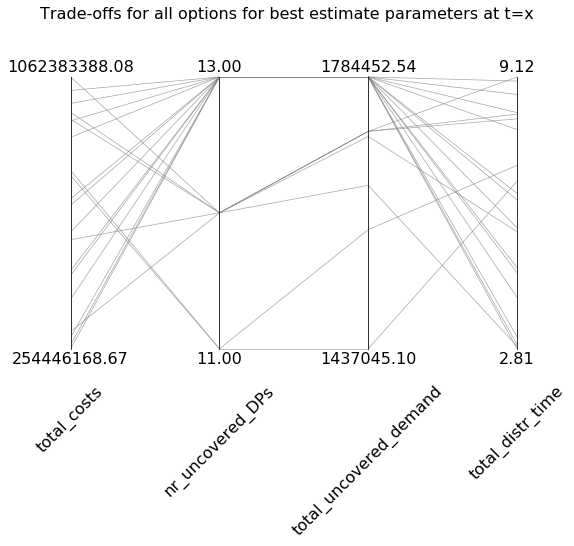

In [17]:
title = "Trade-offs for all options for best estimate parameters at t=x"
plot_optimal(df_best_est_results_opt_pols, oois, title)

In [18]:
# options for pareto sorting# minimising is default
kwargs = {"maximize_all":True}
kwargs2 = {"maximize":[0,1]}

nondominated_BE_policy_results = pareto.eps_sort([list(df_best_est_results_opt_pols.itertuples(index=True))],[1,2,3,4], [1e-9,1e-9,1e-9,1e-9])
# Put outcomes in DF
df_nondominated_BE_policy_results = pd.DataFrame(np.asarray(nondominated_BE_policy_results), columns=["pol_i"]+oois).set_index("pol_i")
df_nondominated_BE_policy_results

,total_costs,nr_uncovered_DPs,total_uncovered_demand,total_distr_time
pol_i,,,,
2.0,2.544462e+08,13.0,1.784453e+06,2.806602
10.0,7.695466e+08,11.0,1.437045e+06,6.699374
11.0,3.058119e+08,12.0,1.645868e+06,2.868712


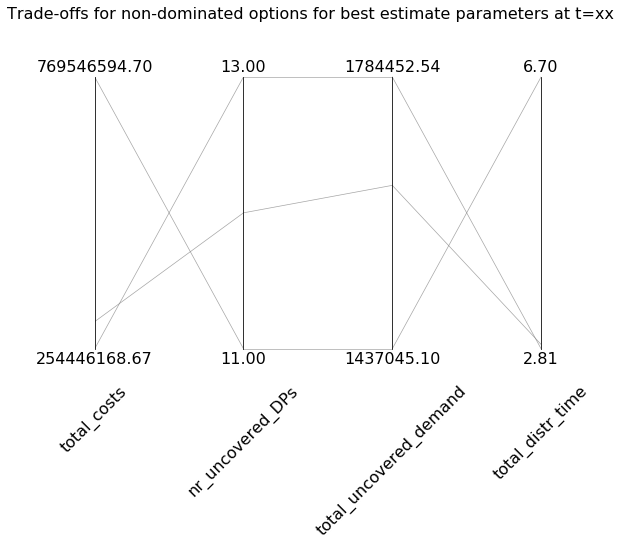

In [19]:
title = "Trade-offs for non-dominated options for best estimate parameters at t=xx"
plot_optimal(df_nondominated_BE_policy_results, oois, title)

In [20]:
# policies for all nondominated policies
nondom_i = [a[0] for a in nondominated_BE_policy_results]

nondominated_BE_policies = np.array(optional_policies)[nondom_i]
nondominated_BE_policies

array([{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 1.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0},
       {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 1.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0},
       {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}],
      dtype=object)

#### visualise all nondom pols

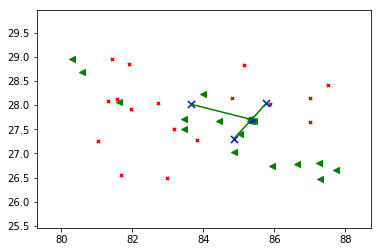

(300.0, 18, 3841704.63688676, 4.915556850219358, 3)

In [22]:
# inspect nondominated results

all_nondom_BE_pols = {name:1 if pos_i in nondom_i else 0 for pos_i, name in enumerate(FLs['Name'])}

FL_model(
    unit_opening_costs=100,
    unit_transport_cost=1,
    graphical_representation=True,
    FL_range=0,
    dist_method="great_circle",
    lorry_speed=60,
    **SPX,
    **SPY,
    **DPX,
    **DPY,
    **FLX,
    **FLY,
    **all_nondom_BE_pols,
    **DSRDP,
    **DSRFL,
    **DPpop)

# EMA Framework

## EMA instantiations

In [23]:
models = []
t = 0
model = Model("flmodelt{}".format(t), FL_model)

model.locations = [
    Constant("DPX{}".format(i), x)
    for i, x in zip(DPs.index, DPs['Longitude (DD)'])
] + [
    Constant("DPY{}".format(i), y)
    for i, y in zip(DPs.index, DPs['Latitude (DD)'])
] + [
    Constant("SPX{}".format(i), x)
    for i, x in zip(SPs.index, SPs['Longitude (DD)'])
] + [
    Constant("SPY{}".format(i), y)
    for i, y in zip(SPs.index, SPs['Latitude (DD)'])
] + [Constant("FLX{}".format(i), x) for i, x in zip(FLs.index, FLs['Lon'])] + [
    Constant("FLY{}".format(i), y) for i, y in zip(FLs.index, FLs['Lat'])
]

# model.locations_uncertain =   [
#     RealParameter("FLX{}".format(i), DPs['Longitude (DD)'].min(), DPs['Longitude (DD)'].max()) for i in range(nr_of_FLs)
# ] + [RealParameter("FLY{}".format(i), DPs['Latitude (DD)'].min(), DPs['Latitude (DD)'].max()) for i in range(nr_of_FLs)]

model.constants = [
    Constant('graphical_representation', False),
    Constant('dist_method', 'great_circle'),
    Constant('Error_Test', 1),  # this doesn't do anything. 
    #list of other constants
    #     Constant
] + model.locations + [ # population DPs
    Constant("DPpop{}".format(i), pop)
    for i, pop in zip(Nepal.index, Nepal['Population'])
]

# Reachability of Demand Points and Facility Locations can be disrupted
# Disruption also determines demand (disr-1)*pop
model.disruptions = [
    RealParameter("DSRFL{}".format(i), 1, 2) for i in range(FLs.shape[0])
] + [RealParameter("DSRDP{}".format(i), 1, 2) for i in range(DPs.shape[0])]

model.uncertainties = [
    RealParameter('unit_opening_costs', 100, 200),
    RealParameter('unit_transport_cost', 0.5,
                  2),  # cost of transporting one unit of relief goods
    RealParameter('FL_range', 100, 300),  # km TODO: great circle distance
    RealParameter(
        'lorry_speed', 30, 60
    ),  # km/h. Speed is Average speed. Constant, because roads are individually disrupted 
    #list of other uncertainties
] + model.disruptions  #+ model.locations_uncertain

model.outcomes = [
    ScalarOutcome("total_costs", kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome("nr_uncovered_DPs", kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome("total_uncovered_demand", kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome(
        "total_distr_time",
        kind=ScalarOutcome.MINIMIZE,
    )
]

models.append(model)

In [24]:
if [o.name for o in models[0].outcomes] != oois:
    print("Watch out! Oois and model outcome names are not similar!")

In [25]:
for model in models:
    print(model.name)

flmodelt0


In [26]:
nondominated_BE_policies_EMA = []
for name, pol in zip(nondom_i,nondominated_BE_policies):
    nondominated_BE_policies_EMA.append(Policy("{}".format(name), **pol))

In [28]:
time1 = time.time()
all_scen_results_nondom_pols = perform_experiments(model,1000,nondominated_BE_policies_EMA)
time2 = time.time()
print("Total time:{}".format(time2-time1),"\n","time per run = {}".format((time2-time1)/1000))

[MainProcess/INFO] performing 1000 scenarios * 3 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:144.36057209968567 
 time per run = 0.14436057209968567


timelog: (3000 experiments)
1. possibly with cpu problems due to failed multiprocessing <br>
Total time:186.64591431617737 <br>
time per run = 0.18664591431617736
2. model v2 <br>
Total time:156.22968077659607  <br>
 time per run = 0.15622968077659607
3. model v2 4 policies <br>
Total time:200.71212720870972 
 time per run = 0.2007121272087097
4. 
Total time:144.36057209968567 <br>
 time per run = 0.14436057209968567

In [29]:
# Add parameter in filename for period t=1,2...x
ema.save_results(all_scen_results_nondom_pols, "results/candidate_policy_robustness_v2.tar.gz")

[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\results\candidate_policy_robustness_v2.tar.gz


# Robustness Framework

In [30]:
all_scen_results_nondom_pols = ema.load_results("results/candidate_policy_robustness_v1.tar.gz")
experiments, outcomes = all_scen_results_nondom_pols

[MainProcess/INFO] results loaded succesfully from C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\results\candidate_policy_robustness_v1.tar.gz


In [31]:
def calculate_signalNoise(data, obj):
    '''
    data : 1d array, the values of an outcome indicator for a policy
    obj  : the objective corresponding to an outcome indicator, 1 or -1
    '''
    if obj == -1: #MINIMIZE
        score = (np.mean(data)+1)*(np.std(data)+1) #to avoid division by zero if the std. deviation is zero, we can add 1.
    elif obj == 1: #MAXIMIZE
        score = (np.mean(data)+1)/(np.std(data)+1)
    return score

sigN_results = []

for policy in nondominated_BE_policies_EMA:
    #filter the outcome values corresponding to each policy using a logical index
    logical_index = experiments['policy']==int(policy.name)
    pol_outcomes = {key:outcomes[key][logical_index] for key in outcomes.keys()}
    temp_result = {}
    for ooi in models[0].outcomes:
        temp_result[ooi.name] = calculate_signalNoise(pol_outcomes[ooi.name], ooi.kind)
    sigN_results.append(temp_result)    


In [35]:
df_sigN = pd.DataFrame(sigN_results, index=[pol.name for pol in nondominated_BE_policies_EMA])
df_sigN

,nr_uncovered_DPs,total_costs,total_distr_time,total_uncovered_demand
2,29.215002,1.171995e+19,831.133449,3.627051e+11
10,18.369744,1.048619e+19,646.963707,2.018095e+11
11,25.031930,8.559711e+18,616.662179,3.071423e+11


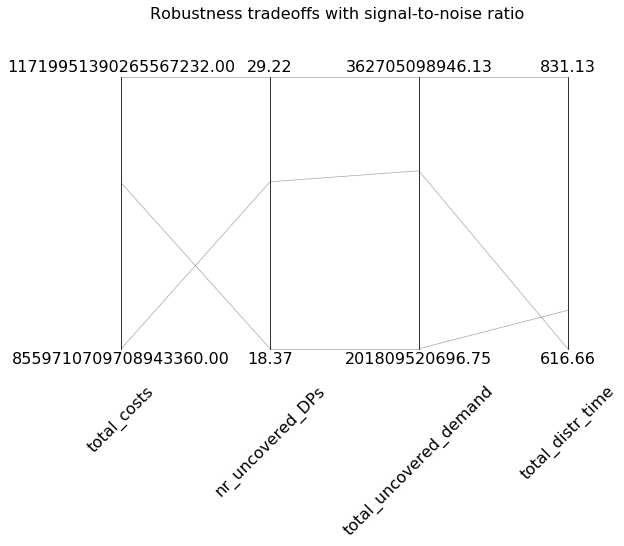

In [36]:

title = "Robustness tradeoffs with signal-to-noise ratio"
plot_optimal(df_sigN, oois, title)

In [37]:
def calculate_maxregret(data, obj):
    '''
    data : a list of 1d arrays whose shape is no_policies x no_scenarios
    obj : -1 or 1, the objective 
    '''
    data = np.array(data)
    if obj == 1: #MAXIMIZE 
        #find the best case in each scenario, therefore use the max function of numpy on the axis of policies
        zero_regrets = np.max(data, axis=0)
    elif obj == -1: #MINIMIZE
        zero_regrets = np.min(data, axis=0)
    
    #determine the regret values for eaxh policy in each scenario
    regrets = [abs(np.subtract(data[p], zero_regrets)) for p in range(data.shape[0])]
    
    max_regrets = np.max(regrets, axis=1)
    
    return max_regrets

In [38]:
reg_results = {}
# we need to iterate over the outcomes differently now, 
#because the maximum egret calculation requires the outcome values for all policies
for ooi in models[0].outcomes:
    data = []
    for policy in nondominated_BE_policies_EMA:
        logical_index = experiments['policy'] == int(policy.name) 
        data.append(outcomes[ooi.name][logical_index])
    reg_results[ooi.name] = calculate_maxregret(data, ooi.kind)
    


In [39]:
reg_results

{'total_costs': array([3.54661429e+09, 2.25650480e+09, 1.62313826e+09]),
 'nr_uncovered_DPs': array([3., 0., 3.]),
 'total_uncovered_demand': array([583291.45521286, 252263.28930526, 583291.45521286]),
 'total_distr_time': array([25.88035795, 17.92584747, 11.39677561])}

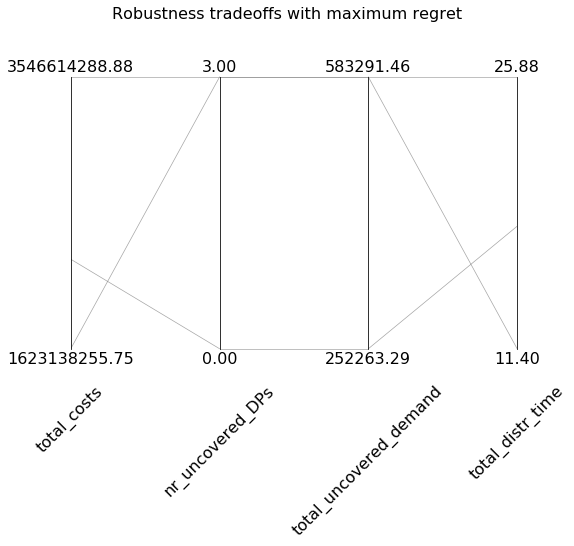

In [42]:
# we can again convert the robustness values into a dataframe. 
#However, since the results are in a dictionary, we need to do it differently.
df_regret = pd.DataFrame.from_dict(reg_results, orient='columns',)
df_regret.index = [pol.name for pol in nondominated_BE_policies_EMA]
title = "Robustness tradeoffs with maximum regret"
plot_optimal(df_regret, oois, title)

## Choose nondominated robust policies

In [43]:
df_regret

,nr_uncovered_DPs,total_costs,total_distr_time,total_uncovered_demand
2,3.0,3.546614e+09,25.880358,583291.455213
10,0.0,2.256505e+09,17.925847,252263.289305
11,3.0,1.623138e+09,11.396776,583291.455213


In [44]:
df_sigN

,nr_uncovered_DPs,total_costs,total_distr_time,total_uncovered_demand
2,29.215002,1.171995e+19,831.133449,3.627051e+11
10,18.369744,1.048619e+19,646.963707,2.018095e+11
11,25.031930,8.559711e+18,616.662179,3.071423e+11


In [45]:
all_robustness_scores = pd.merge(df_regret,df_sigN, left_index=True, right_index=True)

In [49]:
all_robustness_scores

,nr_uncovered_DPs_x,total_costs_x,total_distr_time_x,total_uncovered_demand_x,nr_uncovered_DPs_y,total_costs_y,total_distr_time_y,total_uncovered_demand_y
2,3.0,3.546614e+09,25.880358,583291.455213,29.215002,1.171995e+19,831.133449,3.627051e+11
10,0.0,2.256505e+09,17.925847,252263.289305,18.369744,1.048619e+19,646.963707,2.018095e+11
11,3.0,1.623138e+09,11.396776,583291.455213,25.031930,8.559711e+18,616.662179,3.071423e+11


Use small epsilon value, because efficiency is not relevant (because of low numbers of alternatives, smaller epsilon is possible. larger epsilon leads to faster processing time)

In [50]:
# Non-dominated sorting for outcomes


# options for pareto sorting# minimising is default
kwargs = {"maximize_all":True}
kwargs2 = {"maximize":[0,1]}

robust_nondominated_policies = pareto.eps_sort([list(all_robustness_scores.itertuples(index=True))],[i+1 for i in range(all_robustness_scores.shape[1])], [1e-9] * all_robustness_scores.shape[1])
robust_nondominated_policies

[['10',
  0.0,
  2256504799.390561,
  17.925847473395024,
  252263.28930526495,
  18.369744331018907,
  1.0486187398118541e+19,
  646.9637067029489,
  201809520696.7457],
 ['11',
  3.0,
  1623138255.7464902,
  11.396775609908406,
  583291.4552128604,
  25.031929846900628,
  8.559710709708943e+18,
  616.6621790170805,
  307142314435.13873]]

In [66]:
temp_cols = ["pol_i"]+list(all_robustness_scores.columns)

In [70]:
df_temp = pd.DataFrame(robust_nondominated_policies, columns=temp_cols).set_index("pol_i")

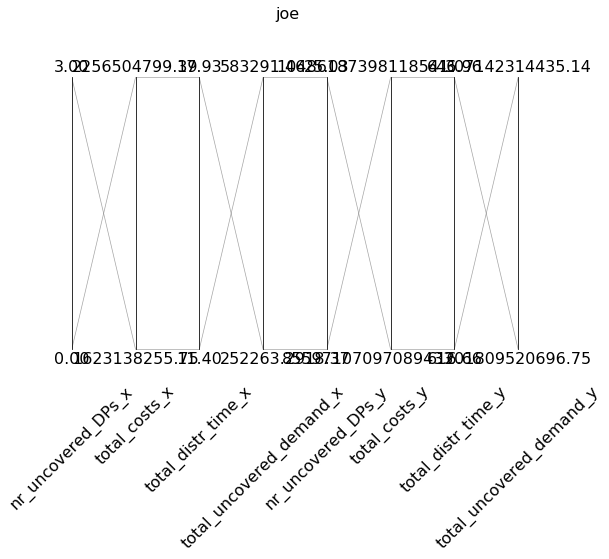

In [72]:
plot_optimal(df_temp, all_robustness_scores.columns, "joe")

# Next iteration Framework